In [62]:
! pip install pyspark


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
! pip install numpy



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import logging

In [65]:
spark = SparkSession.builder \
    .appName("DataCo - Prédiction Retards") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()


In [66]:
df = spark.read.csv("../data/DataCoSupplyChainDataset.csv" , header=True , inferSchema=True )

In [67]:
df.count()

180519

In [68]:
df_status_Late_delivery_risk=df.groupBy("Late_delivery_risk").count()
print("Nombre d'occurrences par catégorie de 'Late_delivery_risk':")
df_status_Late_delivery_risk.show()

Nombre d'occurrences par catégorie de 'Late_delivery_risk':
+------------------+-----+
|Late_delivery_risk|count|
+------------------+-----+
|                 1|98977|
|                 0|81542|
+------------------+-----+



In [69]:
df.groupBy("Delivery Status").count()
print("Nombre d'occurrences par catégorie de 'Delivery Status':")
df.groupBy("Delivery Status").count().show()

Nombre d'occurrences par catégorie de 'Delivery Status':
+-----------------+-----+
|  Delivery Status|count|
+-----------------+-----+
| Shipping on time|32196|
| Advance shipping|41592|
|Shipping canceled| 7754|
|    Late delivery|98977|
+-----------------+-----+



In [70]:
df.show(5)

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per c

Analyse : on supprime les lignes qui contient delivery status == Shipping canceled 

In [71]:
from pyspark.sql.functions import col
df_cleaned = df.filter(col("Delivery Status") != "Shipping canceled")

In [72]:
# ici je verfier est ce que les colis avec "Advance shipping" ont pas de risque de  retard , pour verifier la qualite de donnees
df_analyse= df.select(col("Late_delivery_risk")).filter(col("Delivery Status") == "Advance shipping").groupBy("Late_delivery_risk").count()
df_analyse.show()

+------------------+-----+
|Late_delivery_risk|count|
+------------------+-----+
|                 0|41592|
+------------------+-----+



In [73]:
df_status_Late_delivery_risk=df_cleaned.groupBy("Late_delivery_risk").count() 

# Ajouter une colonne pourcentage
df_status_Late_delivery_risk = df_status_Late_delivery_risk.withColumn(
    "percentage %",
    round(col("count") / df_cleaned.count() * 100, 2)  # arrondi à 2 décimales
)


print("Nombre d'occurrences par catégorie de 'Late_delivery_risk':")
df_status_Late_delivery_risk.show()

Nombre d'occurrences par catégorie de 'Late_delivery_risk':
+------------------+-----+------------+
|Late_delivery_risk|count|percentage %|
+------------------+-----+------------+
|                 1|98977|       57.29|
|                 0|73788|       42.71|
+------------------+-----+------------+



Analyse :  57.29 % ont un retard , alors nos donnees sont equilibré

maintenant on passe a la supprission des colonnes inutils 

In [97]:
cols_to_drop = [
    "Customer Email",  
    "Customer Password", 
    "Customer Street",
    "Customer Zipcode",
    "Customer Fname", 
    "Customer Lname", 
    "Product Description", 
    "Product Image",
    "Order Zipcode", 
    "Order Customer Id", 
    "Order Item Cardprod Id", 
    "Order Item Id",
    "Product Card Id"
]

# Garde seulement les colonnes qui existent dans le DataFrame
existing_cols_to_drop = [c for c in cols_to_drop if c in df_cleaned.columns]

# Supprimer ces colonnes
df_cleaned = df_cleaned.drop(*existing_cols_to_drop)

# Vérifier les colonnes restantes
print(df_cleaned.columns)



['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Delivery Status', 'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City', 'Customer Country', 'Customer Id', 'Customer Segment', 'Customer State', 'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market', 'Order City', 'Order Country', 'order date (DateOrders)', 'Order Id', 'Order Item Discount', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Region', 'Order State', 'Order Status', 'Product Name', 'Product Price', 'shipping date (DateOrders)', 'Shipping Mode']


In [75]:
df_cleaned.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Department Id: integer (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Market: string (nullable = true)
 |-- Order City: string (nullable = true)
 |-- Order Country: string (nullable = true)
 |-- order date (DateOrd

In [76]:
from pyspark.sql.functions import col, mean

# Calculer le pourcentage de retards par mode d'expédition
df_risk_by_mode = df_cleaned.groupBy("Shipping Mode") \
    .agg(mean(col("Late_delivery_risk")).alias("Late_delivery_rate")) \
    .orderBy(col("Late_delivery_rate").desc())

df_risk_by_mode.show()


+--------------+-------------------+
| Shipping Mode| Late_delivery_rate|
+--------------+-------------------+
|   First Class|                1.0|
|  Second Class| 0.7982902443353251|
|      Same Day|0.47928548369740664|
|Standard Class|0.39769080879858076|
+--------------+-------------------+



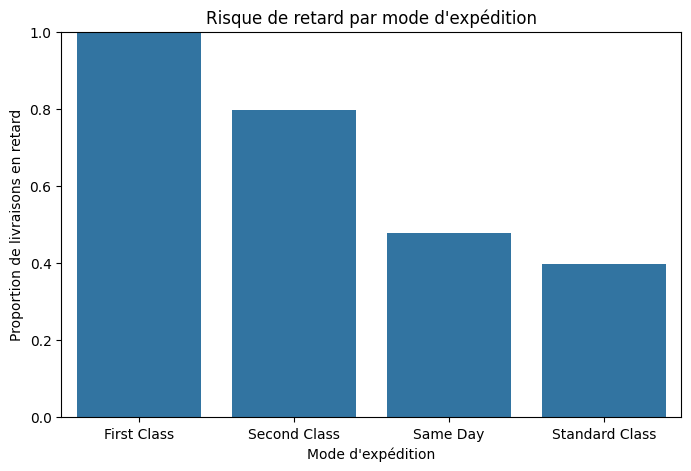

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Conversion en Pandas
df_risk_pd = df_risk_by_mode.toPandas()

# Bar plot
plt.figure(figsize=(8,5))
sns.barplot(x="Shipping Mode", y="Late_delivery_rate", data=df_risk_pd)
plt.title("Risque de retard par mode d'expédition")
plt.ylabel("Proportion de livraisons en retard")
plt.xlabel("Mode d'expédition")
plt.ylim(0, 1)
plt.show()


## VARIANCE

In [78]:
from pyspark.sql.functions import col, variance
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F

# 1️⃣ Sélectionner les colonnes numériques
numeric_cols = [c for c, t in df_cleaned.dtypes if t in ['int', 'double', 'float'] and c not in ['Late_delivery_risk', 'Order Id']]

# 2️⃣ Calculer la variance de chaque colonne
variances = (
    df_cleaned.select([variance(col(c)).alias(c) for c in numeric_cols])
    .collect()[0]
    .asDict()
)

# 3️⃣ Choisir un seuil de variance (comme sklearn.threshold=0.01)
threshold = 0.01

# 4️⃣ Séparer features gardées / supprimées
features_gardees = [c for c, v in variances.items() if v is not None and v > threshold]
features_supprimees = [c for c, v in variances.items() if v is None or v <= threshold]

# 5️⃣ Créer un nouveau DataFrame filtré
df_var = df_cleaned.select(features_gardees + ['Late_delivery_risk'])

# 6️⃣ Afficher les résultats
print(f"✅ Features gardées ({len(features_gardees)}) : {features_gardees}")
print(f"❌ Features supprimées ({len(features_supprimees)}) : {features_supprimees}")




✅ Features gardées (18) : ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Category Id', 'Customer Id', 'Department Id', 'Latitude', 'Longitude', 'Order Item Discount', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Product Category Id', 'Product Price']
❌ Features supprimées (2) : ['Order Item Discount Rate', 'Product Status']


Analyse : 
❌ Features supprimées (2) : ['Order Item Discount Rate', 'Product Status']
apres la correlation on a constater que ces deux features n'apportent pas d'information pertinente pour la prédiction
et apres l analyse des valeurs avec group by on a constater que ces deux features n ont pas de relation claire avec la variable cible 'Late_delivery_risk'

In [79]:
df_cleaned = df.drop('Order Item Discount Rate', 'Product Status')


In [80]:
len(df_cleaned.columns)

51

## CORRELATION 

In [81]:
df_cleaned.cache()  # On demande à Spark de mettre le DataFrame en cache pour le réutiliser plus tard
df_cleaned.count()


180519

In [82]:
! pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [83]:
NUMERIC_COLS = [c for c, t in df_cleaned.dtypes if t in ['int', 'double', 'float'] and c != 'Late_delivery_risk']

                               Days for shipping (real)  \
Days for shipping (real)                       1.000000   
Days for shipment (scheduled)                  0.515880   
Benefit per order                             -0.005101   
Sales per customer                             0.001757   
Category Id                                   -0.000348   
Customer Id                                    0.003432   
Customer Zipcode                               0.000112   
Department Id                                 -0.001631   
Latitude                                      -0.004073   
Longitude                                      0.003911   
Order Customer Id                              0.003432   
Order Id                                      -0.001711   
Order Item Cardprod Id                        -0.000859   
Order Item Discount                            0.002231   
Order Item Id                                 -0.001769   
Order Item Product Price                       0.002185 

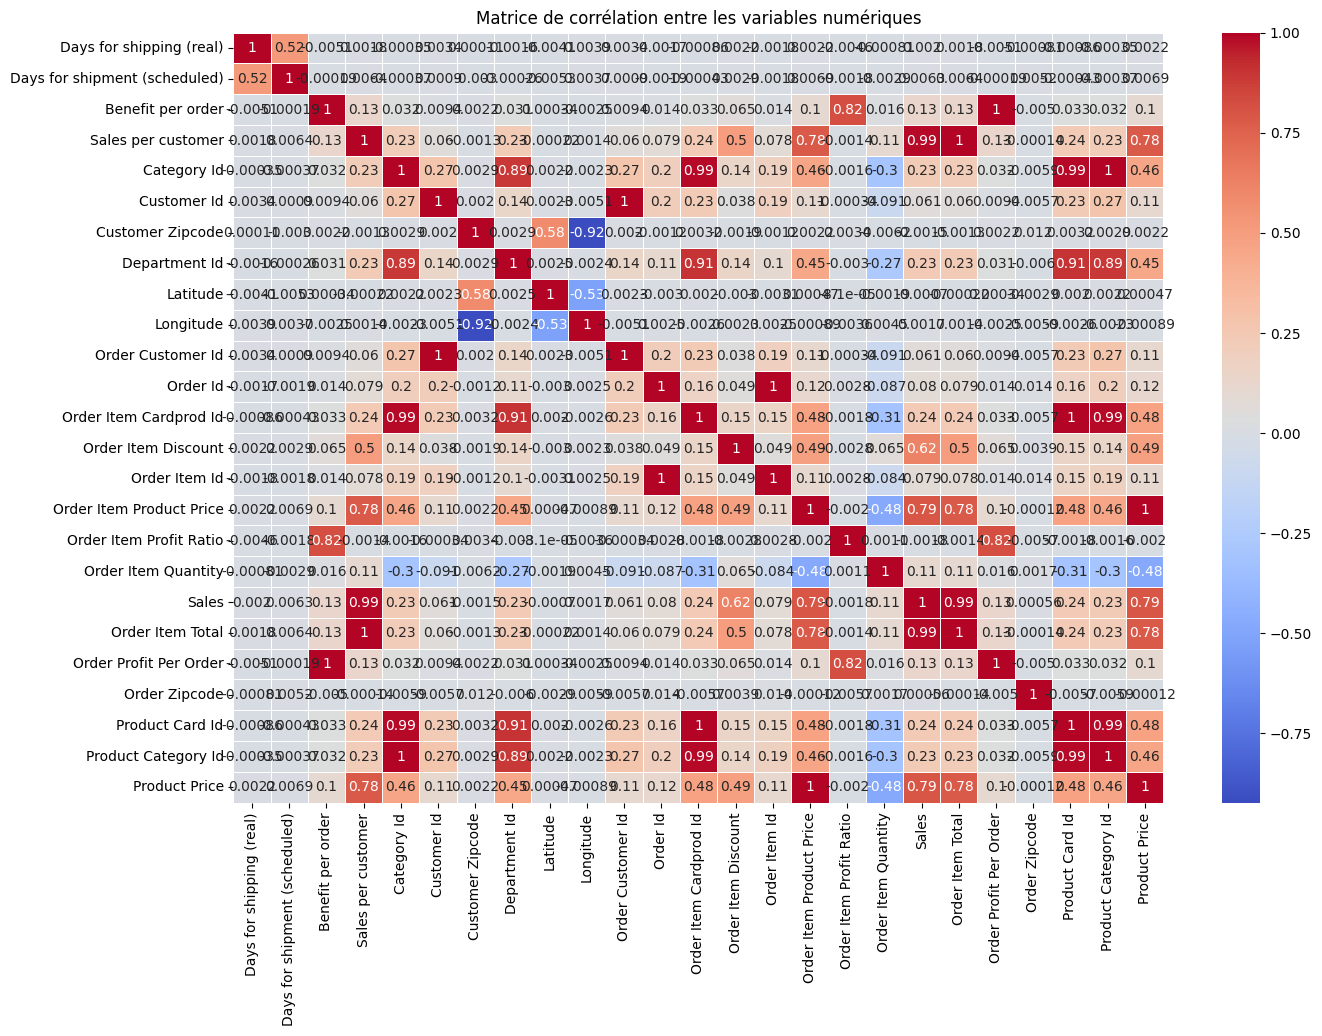

In [84]:
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection des colonnes numériques
numeric_df = df_cleaned.select([col(c).cast("double") for c in NUMERIC_COLS])

# Conversion en pandas pour calculer la matrice de corrélation
pandas_df = numeric_df.toPandas()

# Calcul de la matrice de corrélation
corr_matrix = pandas_df.corr()

# Affichage sous forme de tableau
print(corr_matrix)

# Visualisation graphique (heatmap)
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de corrélation entre les variables numériques")
plt.show()


# correlation plus de 0.8

                   Variable_1                Variable_2  Correlation
70          Benefit per order    Order Profit Per Order     1.000000
94         Sales per customer          Order Item Total     1.000000
123               Category Id       Product Category Id     1.000000
562           Product Card Id    Order Item Cardprod Id     1.000000
322    Order Item Cardprod Id           Product Card Id     1.000000
399  Order Item Product Price             Product Price     1.000000
255         Order Customer Id               Customer Id     1.000000
135               Customer Id         Order Customer Id     1.000000
615             Product Price  Order Item Product Price     1.000000
579       Product Category Id               Category Id     1.000000
502    Order Profit Per Order         Benefit per order     1.000000
478          Order Item Total        Sales per customer     1.000000
361             Order Item Id                  Order Id     0.999623
289                  Order Id     

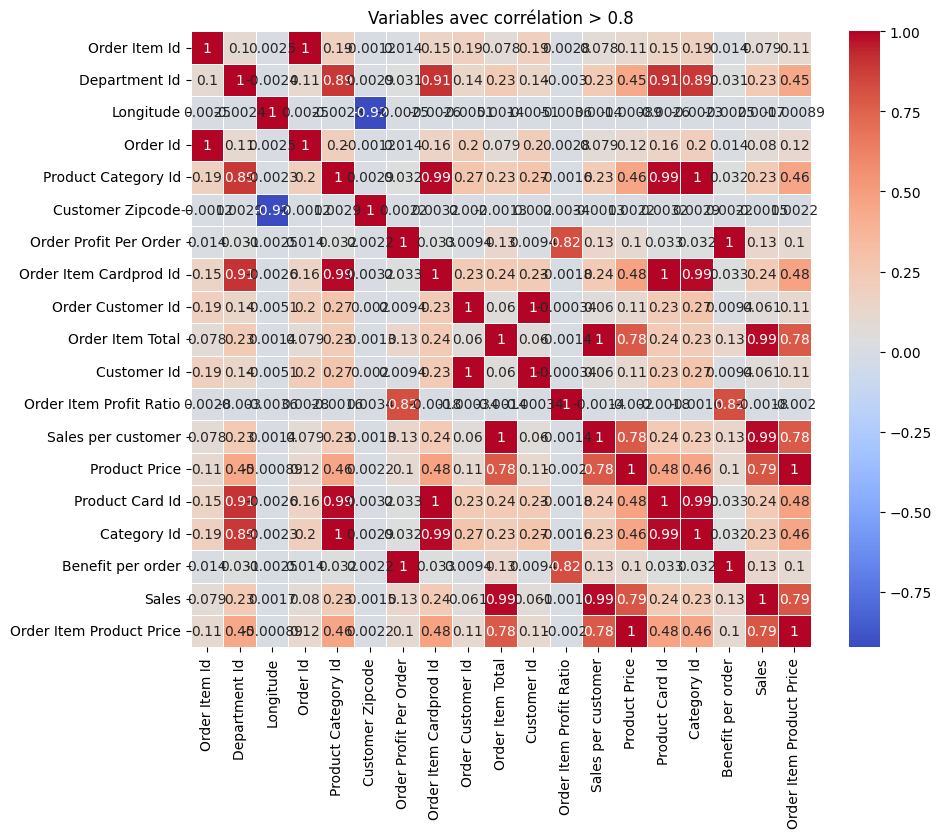

In [85]:
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df_cleaned.select([col(c).cast("double") for c in NUMERIC_COLS])
pandas_df = numeric_df.toPandas()
corr_matrix = pandas_df.corr()

corr_pairs = (
    corr_matrix.unstack()
    .reset_index()
    .rename(columns={'level_0': 'Variable_1', 'level_1': 'Variable_2', 0: 'Correlation'})
)

high_corr = corr_pairs[
    (corr_pairs['Variable_1'] != corr_pairs['Variable_2']) &
    (corr_pairs['Correlation'].abs() > 0.8)
].sort_values(by='Correlation', ascending=False).drop_duplicates()

print(high_corr)

# 🔧 Correction : convertir en liste
cols_high_corr = list(set(high_corr['Variable_1']).union(set(high_corr['Variable_2'])))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[cols_high_corr, cols_high_corr], annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Variables avec corrélation > 0.8")
plt.show()


In [86]:
# Suppression des colonnes à haute corrélation
cols_to_drop = [
    "Order Item Cardprod Id",
    "Order Customer Id",
    "Order Item Product Price",
    "Order Profit Per Order",
    "Order Item Total",
    "Order Item Id",
    "Product Category Id"
]

# Garde seulement les colonnes qui existent dans le DataFrame
existing_cols_to_drop = [c for c in cols_to_drop if c in df_cleaned.columns]

print(f"📋 Colonnes à supprimer : {len(existing_cols_to_drop)}")
print(existing_cols_to_drop)

# ✅ SUPPRESSION PYSPARK (méthode correcte)
df_cleaned = df_cleaned.drop(*existing_cols_to_drop)

# Vérifier les colonnes restantes
print(f"\n✅ Colonnes restantes : {len(df_cleaned.columns)}")
print(df_cleaned.columns)

# Vérifier que les colonnes ont bien disparu
print("\n🔍 Vérification :")
for col in cols_to_drop:
    if col in df_cleaned.columns:
        print(f"❌ ERREUR : '{col}' est toujours présente !")
    else:
        print(f"✅ '{col}' supprimée avec succès")

📋 Colonnes à supprimer : 7
['Order Item Cardprod Id', 'Order Customer Id', 'Order Item Product Price', 'Order Profit Per Order', 'Order Item Total', 'Order Item Id', 'Product Category Id']

✅ Colonnes restantes : 44
['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Delivery Status', 'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City', 'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id', 'Customer Lname', 'Customer Password', 'Customer Segment', 'Customer State', 'Customer Street', 'Customer Zipcode', 'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market', 'Order City', 'Order Country', 'order date (DateOrders)', 'Order Id', 'Order Item Discount', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Region', 'Order State', 'Order Status', 'Order Zipcode', 'Product Card Id', 'Product Description', 'Product Image', 'Product Name', 'Product Price', 'shipping date 

In [90]:
len(df_cleaned.columns)



44

In [88]:
# Exécutez ceci pour savoir quel type de DataFrame vous avez
print(type(df_cleaned))

<class 'pyspark.sql.classic.dataframe.DataFrame'>


                  Variable_1               Variable_2  Correlation
88               Category Id          Product Card Id     0.991092
292          Product Card Id              Category Id     0.991092
255                    Sales       Sales per customer     0.989744
68        Sales per customer                    Sales     0.989744
142            Department Id          Product Card Id     0.906117
295          Product Card Id            Department Id     0.906117
130            Department Id              Category Id     0.888835
79               Category Id            Department Id     0.888835
48         Benefit per order  Order Item Profit Ratio     0.823689
218  Order Item Profit Ratio        Benefit per order     0.823689
168                Longitude         Customer Zipcode    -0.923921
117         Customer Zipcode                Longitude    -0.923921


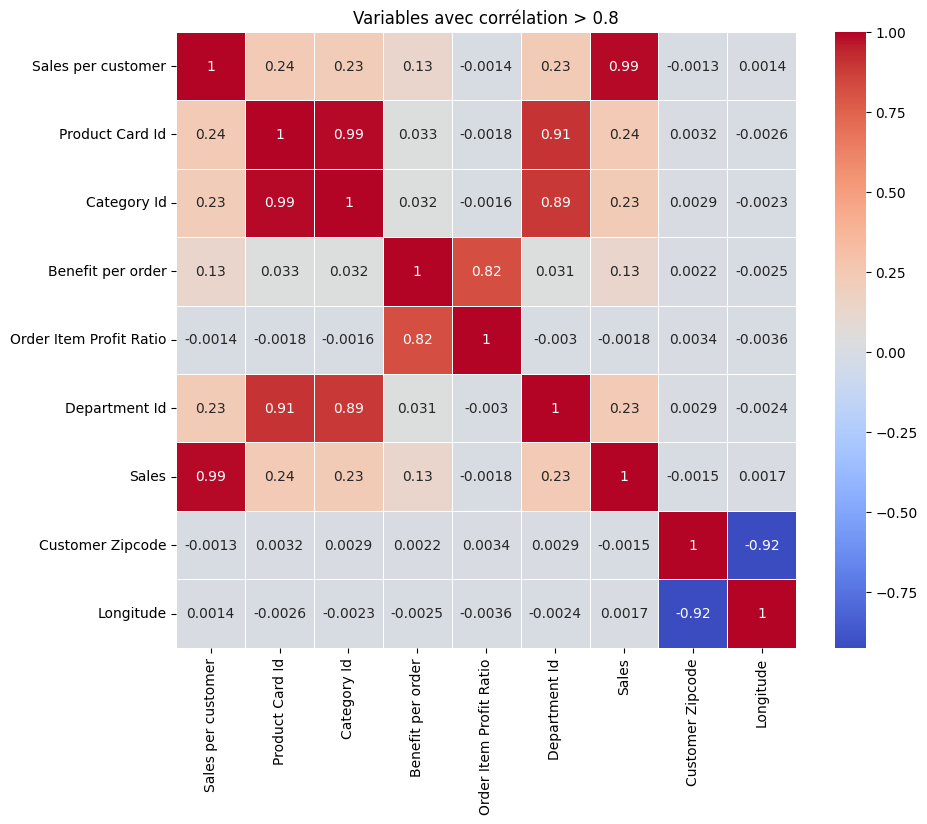

In [94]:
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
NUMERIC_COLS = [c for c, t in df_cleaned.dtypes if t in ['int', 'double', 'float'] and c != 'Late_delivery_risk']
numeric_df = df_cleaned.select([col(c).cast("double") for c in NUMERIC_COLS])
pandas_df = numeric_df.toPandas()
corr_matrix = pandas_df.corr()

corr_pairs = (
    corr_matrix.unstack()
    .reset_index()
    .rename(columns={'level_0': 'Variable_1', 'level_1': 'Variable_2', 0: 'Correlation'})
)

high_corr = corr_pairs[
    (corr_pairs['Variable_1'] != corr_pairs['Variable_2']) &
    (corr_pairs['Correlation'].abs() > 0.8)
].sort_values(by='Correlation', ascending=False).drop_duplicates()

print(high_corr)

# 🔧 Correction : convertir en liste
cols_high_corr = list(set(high_corr['Variable_1']).union(set(high_corr['Variable_2'])))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[cols_high_corr, cols_high_corr], annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Variables avec corrélation > 0.8")
plt.show()


# Analyse correlation : 
✅ Analyse des Corrélations Restantes
Voici pourquoi ces corrélations sont à conserver :
1. Hiérarchie Produit (r ≈ 0.89-0.99)
Department Id ↔ Category Id ↔ Product Card Id

Corrélation logique : Hiérarchie naturelle des produits
À garder : Information à différents niveaux de granularité utile pour la logistique
Impact métier : Certains départements/catégories ont peut-être plus de retards

2. Ventes (r = 0.99)
Sales ↔ Sales per customer

Différence : Vue globale vs. vue client
À garder : Perspectives complémentaires pour l'analyse
Impact métier : Les gros clients peuvent avoir des délais différents

3. Rentabilité (r = 0.82)
Benefit per order ↔ Order Item Profit Ratio

Corrélation acceptable : < 0.95
À garder : Montant absolu vs. ratio (informations différentes)

4. Géolocalisation (r = -0.92)
Customer Zipcode ↔ Longitude

CRITIQUE À GARDER : Information géographique essentielle pour les retards !
Corrélation naturelle : Le code postal détermine la longitude (géographie réelle)
Impact métier : Distance de livraison = facteur #1 des retards


📊 Diagnostic Final : Dataset PRÊT ✅
✅ Corrélations parfaites (1.0) : ÉLIMINÉES
✅ Corrélations restantes : NORMALES et utiles
✅ Multicolinéarité critique : RÉSOLUE

🎯 Décision : Faut-il Supprimer Plus de Variables ?
Option 1 : Conserver Toutes (RECOMMANDÉ pour la prévision des retards)
python# Rien à faire, le dataset est prêt !
print("✅ Dataset optimisé et prêt pour la modélisation")
Justification :

Les corrélations < 0.95 apportent de l'information unique
La géolocalisation est cruciale pour les retards de livraison
La hiérarchie produit peut révéler des patterns logistiqu

In [95]:
# nombre de features restantes
len(df_cleaned.columns)

44

In [98]:
df_cleaned.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Department Id: integer (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Market: string (nullable = true)
 |-- Order City: string (nullable = true)
 |-- Order Country: string (nullable = true)
 |-- order date (DateOrd

## chi2


In [99]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql.functions import col
import pandas as pd

# ====================================
# 1. VARIABLES CATÉGORIELLES DE VOTRE DATASET
# ====================================
categorical_cols = [
    "Type",
    "Delivery Status",
    "Category Name",
    "Customer City",
    "Customer Country",
    "Customer Segment",
    "Customer State",
    "Department Name",
    "Market",
    "Order City",
    "Order Country",
    "Order Region",
    "Order State",
    "Order Status",
    "Product Name",
    "Shipping Mode"
]

print(f"📋 Variables catégorielles à tester : {len(categorical_cols)}")
for i, col_name in enumerate(categorical_cols, 1):
    print(f"{i}. {col_name}")

📋 Variables catégorielles à tester : 16
1. Type
2. Delivery Status
3. Category Name
4. Customer City
5. Customer Country
6. Customer Segment
7. Customer State
8. Department Name
9. Market
10. Order City
11. Order Country
12. Order Region
13. Order State
14. Order Status
15. Product Name
16. Shipping Mode


In [100]:
# ====================================
# 2. ENCODER LES VARIABLES CATÉGORIELLES
# ====================================
print("\n🔄 Encodage des variables catégorielles...")

df_encoded = df_cleaned

for col_name in categorical_cols:
    indexer = StringIndexer(
        inputCol=col_name, 
        outputCol=f"{col_name}_indexed", 
        handleInvalid="keep"
    )
    df_encoded = indexer.fit(df_encoded).transform(df_encoded)

print("✅ Encodage terminé")


🔄 Encodage des variables catégorielles...
✅ Encodage terminé


In [101]:
# ====================================
# 3. TESTER CHAQUE VARIABLE AVEC CHI-SQUARE
# ====================================
print("\n📊 Test du Chi-Square (peut prendre quelques minutes)...\n")

chi_square_results = []

for i, col_name in enumerate(categorical_cols, 1):
    try:
        print(f"[{i}/{len(categorical_cols)}] Test de '{col_name}'...", end=" ")
        
        # Assembler la feature en vecteur
        assembler = VectorAssembler(
            inputCols=[f"{col_name}_indexed"],
            outputCol="features",
            handleInvalid="skip"
        )
        df_vector = assembler.transform(df_encoded).select("features", "Late_delivery_risk")
        
        # Test du Chi-Square
        chi_result = ChiSquareTest.test(df_vector, "features", "Late_delivery_risk").head()
        
        chi_square_results.append({
            "Variable": col_name,
            "Chi-Square": float(chi_result.statistics[0]),
            "P-value": float(chi_result.pValues[0]),
            "Degrees of Freedom": int(chi_result.degreesOfFreedom[0])
        })
        
        print("✅")
        
    except Exception as e:
        print(f"❌ Erreur: {str(e)[:50]}")


📊 Test du Chi-Square (peut prendre quelques minutes)...

[1/16] Test de 'Type'... ✅
[2/16] Test de 'Delivery Status'... ✅
[3/16] Test de 'Category Name'... ✅
[4/16] Test de 'Customer City'... ✅
[5/16] Test de 'Customer Country'... ✅
[6/16] Test de 'Customer Segment'... ✅
[7/16] Test de 'Customer State'... ✅
[8/16] Test de 'Department Name'... ✅
[9/16] Test de 'Market'... ✅
[10/16] Test de 'Order City'... ✅
[11/16] Test de 'Order Country'... ✅
[12/16] Test de 'Order Region'... ✅
[13/16] Test de 'Order State'... ✅
[14/16] Test de 'Order Status'... ✅
[15/16] Test de 'Product Name'... ✅
[16/16] Test de 'Shipping Mode'... ✅


In [102]:
# ====================================
# 4. AFFICHER LES RÉSULTATS
# ====================================
chi_df = pd.DataFrame(chi_square_results).sort_values("P-value")

print("\n" + "="*90)
print("📈 RÉSULTATS DU TEST CHI-SQUARE (trié par P-value)")
print("="*90)
print(chi_df.to_string(index=False))


📈 RÉSULTATS DU TEST CHI-SQUARE (trié par P-value)
        Variable    Chi-Square      P-value  Degrees of Freedom
            Type   1103.922833 0.000000e+00                   3
 Delivery Status 180519.000000 0.000000e+00                   3
   Customer City   1879.543360 0.000000e+00                 562
   Shipping Mode  37716.042505 0.000000e+00                   3
     Order State   4286.408616 0.000000e+00                1088
    Order Status   9854.657149 0.000000e+00                   8
   Order Country    580.041562 0.000000e+00                 163
      Order City  14195.298421 0.000000e+00                3596
    Order Region     74.933614 1.083130e-07                  22
  Customer State    101.077792 3.411002e-06                  45
          Market      8.650714 7.044823e-02                   4
Customer Segment      1.024740 5.990741e-01                   2
Customer Country      0.196677 6.574163e-01                   1
   Category Name     42.889228 7.179808e-01          

c:\Users\elkho\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\elkho\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


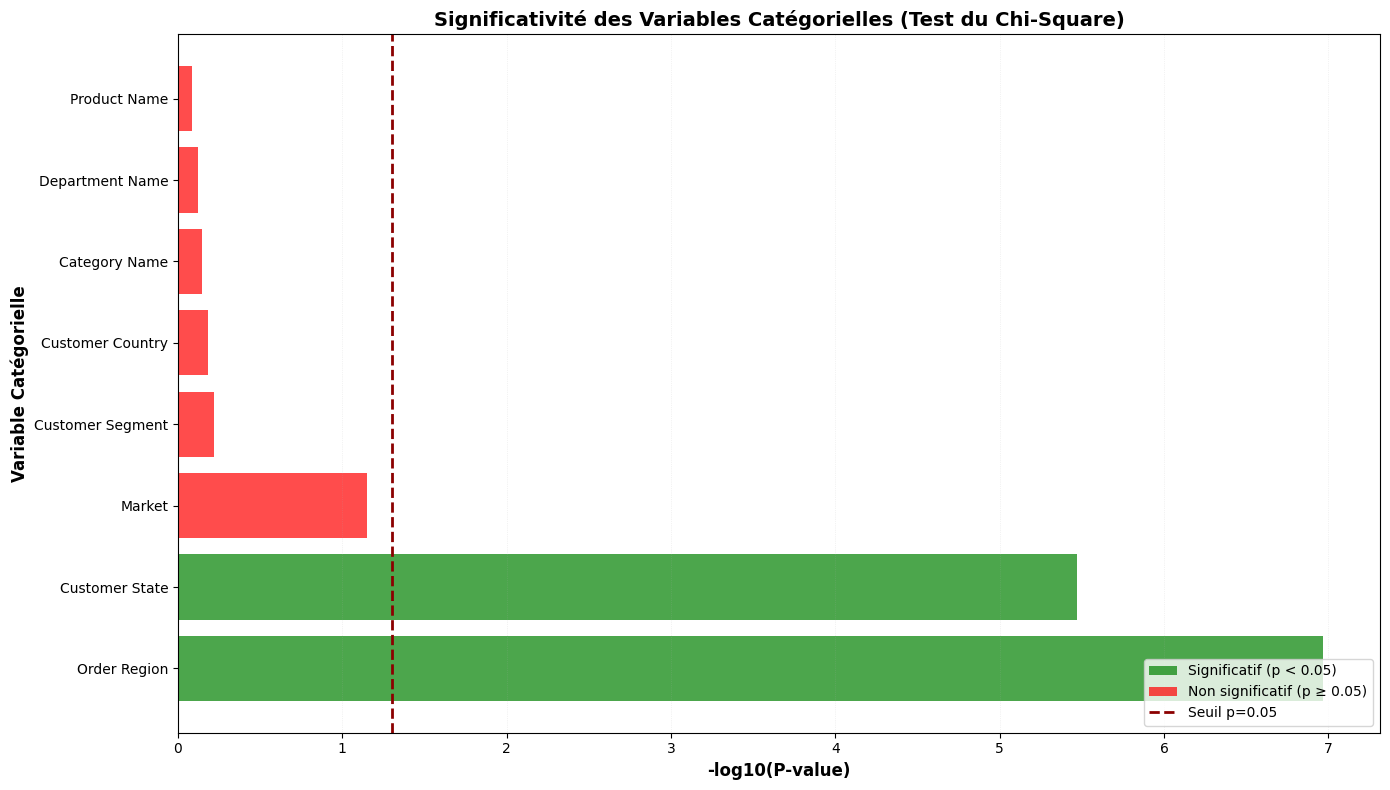

In [104]:
# ====================================
# 5. VISUALISATION
# ====================================
import matplotlib.pyplot as plt
import numpy as np

# Calculer -log10(p-value) pour une meilleure visualisation
chi_df['neg_log_pvalue'] = -np.log10(chi_df['P-value'])

# Créer la figure
plt.figure(figsize=(14, 8))

# Créer le graphique en barres horizontales
colors = ['green' if p < 0.05 else 'red' for p in chi_df['P-value']]
plt.barh(chi_df['Variable'], chi_df['neg_log_pvalue'], color=colors, alpha=0.7)

# Ligne de seuil de significativité (p=0.05)
threshold = -np.log10(0.05)
plt.axvline(x=threshold, color='darkred', linestyle='--', linewidth=2, label=f'Seuil p=0.05 (-log10={threshold:.2f})')

# Labels et titre
plt.xlabel('-log10(P-value)', fontsize=12, fontweight='bold')
plt.ylabel('Variable Catégorielle', fontsize=12, fontweight='bold')
plt.title('Significativité des Variables Catégorielles (Test du Chi-Square)', fontsize=14, fontweight='bold')

# Légende
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Significatif (p < 0.05)'),
    Patch(facecolor='red', alpha=0.7, label='Non significatif (p ≥ 0.05)'),
    plt.Line2D([0], [0], color='darkred', linewidth=2, linestyle='--', label='Seuil p=0.05')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

# Grille pour faciliter la lecture
plt.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.5)

# Ajuster la mise en page
plt.tight_layout()
plt.show()


In [107]:
# ====================================
# TABLEAU RÉCAPITULATIF
# ====================================
print("\n" + "="*90)
print("📊 RÉCAPITULATIF DES P-VALUES")
print("="*90)

# Ajouter une colonne de significativité
chi_df['Significatif'] = chi_df['P-value'].apply(lambda x: '✅ Oui' if x < 0.05 else '❌ Non')

# Afficher le tableau complet
print(chi_df[['Variable', 'Chi-Square', 'P-value', 'Significatif']].to_string(index=False))

print("\n" + "="*90)
print(f"✅ Variables significatives (p < 0.05)   : {len(chi_df[chi_df['P-value'] < 0.05])}")
print(f"❌ Variables non significatives (p ≥ 0.05) : {len(chi_df[chi_df['P-value'] >= 0.05])}")
print("="*90)


📊 RÉCAPITULATIF DES P-VALUES
        Variable    Chi-Square      P-value Significatif
            Type   1103.922833 0.000000e+00        ✅ Oui
 Delivery Status 180519.000000 0.000000e+00        ✅ Oui
   Customer City   1879.543360 0.000000e+00        ✅ Oui
   Shipping Mode  37716.042505 0.000000e+00        ✅ Oui
     Order State   4286.408616 0.000000e+00        ✅ Oui
    Order Status   9854.657149 0.000000e+00        ✅ Oui
   Order Country    580.041562 0.000000e+00        ✅ Oui
      Order City  14195.298421 0.000000e+00        ✅ Oui
    Order Region     74.933614 1.083130e-07        ✅ Oui
  Customer State    101.077792 3.411002e-06        ✅ Oui
          Market      8.650714 7.044823e-02        ❌ Non
Customer Segment      1.024740 5.990741e-01        ❌ Non
Customer Country      0.196677 6.574163e-01        ❌ Non
   Category Name     42.889228 7.179808e-01        ❌ Non
 Department Name      6.666695 7.564916e-01        ❌ Non
    Product Name    103.122165 8.164060e-01        ❌ Non



In [108]:
# ====================================
# SUPPRESSION DES VARIABLES NON SIGNIFICATIVES
# ====================================

# Variables à supprimer (p-value >= 0.05)
non_significant_vars = [
    "Market",
    "Customer Segment",
    "Customer Country",
    "Category Name",
    "Department Name",
    "Product Name"
]

# Supprimer
df_after_chi = df_cleaned.drop(*non_significant_vars)


In [109]:
len(df_after_chi.columns)

28

🔴 Facteurs CRITIQUES de retard identifiés :

Delivery Status (Chi² = 180,519)

💡 Insight : Le statut de livraison actuel est le meilleur prédicteur
🎯 Action : Monitorer en temps réel les changements de statut


Shipping Mode (Chi² = 37,716)

💡 Insight : Certains modes de livraison (Standard, Express, Same Day) ont des taux de retard différents
🎯 Action : Optimiser le choix du transporteur par mode


Order City (Chi² = 14,195)

💡 Insight : Certaines villes ont systématiquement plus de retards
🎯 Action : Créer des alertes pour les zones à risque


Order Status (Chi² = 9,854)

💡 Insight : Le statut de commande impacte la probabilité de retard
🎯 Action : Prioriser les commandes "PENDING" ou "PROCESSING"



✅ Facteurs NON pertinents (surprises) :

❌ Product Name : Le produit spécifique n'impacte pas les retards

💡 Peut-être que c'est plutôt le poids/volume qui compte (pas le nom)


❌ Customer Segment : Consumer/Corporate/Home Office n'ont pas d'impact

💡 Tous les segments subissent les mêmes risques de retard


❌ Category Name : La catégorie de produit n'est pas discriminante

💡 Les retards sont indépendants du type de produit

In [110]:
df_after_chi.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Department Id: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Order City: string (nullable = true)
 |-- Order Country: string (nullable = true)
 |-- order date (DateOrders): string (nullable = true)
 |-- Order Id: integer (nullable = true)
 |-- Order Item Discount: double (nullable = true)
 |-- Order Item Profit Ratio: double (nullable = true)
 |-- Order Item Quantity: integer (nullable = tr